# Recommendation Boost — A/B-тест нового алгоритма в приложении


## Цели проекта
Целью проекта является оценка результатов A/B-теста, проведённого на платформе, чтобы определить влияние изменений в продукте на поведение пользователей. Для этого необходимо проверить корректность проведения эксперимента и выявить, существует ли статистически значимое различие в метриках между тестовой и контрольной группами.

## Задачи проекта
- Исследовать и подготовить данные:
    - Проверить целостность и корректность данных.
    - Объединить исторические и экспериментальные выборки для анализа.

- Оценить корректность A/B-теста:
    - Проверить равномерность распределения пользователей по тестовым группам.
    - Убедиться в отсутствии перекрёстных пользователей (пересечения групп).
    - Сравнить поведение групп до начала эксперимента (при наличии данных).

- Провести анализ результатов эксперимента:
    - Сравнить ключевые метрики (например, длину сессий, количество просмотренных страниц, частоту посещений) между группами.
    - Рассчитать статистическую значимость различий.

- Сделать выводы и рекомендации:
    - Оценить, повлияли ли изменения на поведение пользователей.
    - Рекомендовать действия на основе полученных результатов (например, внедрять изменения или отклонить их).



## Описание данных
Проект использует три датасета, содержащих данные о пользовательских сессиях в мобильном приложении:

`sessions_project_history.csv`
Исторические данные о сессиях пользователей в период с 2025-08-15 по 2025-09-23.
Используются для бенчмаркинга и проверки корректности сплитования групп.

`sessions_project_test_part.csv`
Данные за первый день A/B-теста (2025-10-14).
Предназначены для предварительной проверки запуска эксперимента.

`sessions_project_test.csv`
Данные за весь период эксперимента: с 2025-10-14 по 2025-11-02.
Используются для финального анализа результатов теста.

Общие поля в таблицах:

`user_id` — уникальный ID пользователя;

`session_id` — ID сессии;

`session_date` — дата сессии;

`session_start_ts` — дата и время начала сессии;

`install_date` — дата установки приложения;

`session_number` — порядковый номер сессии пользователя;

`registration_flag` — зарегистрирован ли пользователь;

`page_counter` — количество просмотренных страниц;

`region` — регион пользователя;

`device` — устройство;

`test_group` — группа в эксперименте (есть только в тестовых таблицах).



## Содержимое проекта
Проект состоит из следующих этапов:
- Загрузка и первичный осмотр данных.
- Очистка и предварительная обработка.
- Анализ распределения пользователей по группам.
- Проверка равномерности и случайности распределения.
- Выбор ключевых метрик для анализа.
- Проведение статистических тестов.
- Интерпретация результатов.
- Формулирование выводов и рекомендаций.



##  Загрузка и первичный осмотр данных.


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats as stats
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from math import ceil 
from statsmodels.stats.power import NormalIndPower

In [2]:
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [3]:
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [4]:
sessions_history.tail()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
435919,769BC199AF26FEF8,914903B51D69C5EA,2025-09-17,2025-09-17 21:33:57,2025-09-04,3,1,3,CIS,PC
435920,599DED39F3CD2ADE,66ADBE343C94DCDA,2025-09-17,2025-09-17 17:11:46,2025-09-04,4,0,4,MENA,iPhone
435921,1FA20C4BC94E64B2,C4CCD7E81733665F,2025-09-17,2025-09-17 19:36:55,2025-09-04,4,0,4,CIS,Android
435922,88E5FC3016A7A0AD,6834FB4914B56200,2025-09-17,2025-09-17 22:13:33,2025-09-04,5,0,4,MENA,PC
435923,5CC144801F7B0D1D,8CC9E67AFF5D9CA8,2025-09-17,2025-09-17 15:23:46,2025-09-04,3,0,2,MENA,iPhone


In [5]:
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


### Поиск числа уникальных сессий для каждого клиента 

In [6]:
unique_session_count = sessions_history.groupby('user_id')['session_id'].nunique().sort_values(ascending = False)
unique_session_count.head()

user_id
10E0DEFC1ABDBBE0    10
6A73CB5566BB494D    10
D11541BAC141FB94     9
E8ADFF2913E86056     9
FA752AB58040C361     9
Name: session_id, dtype: int64

In [7]:
max_session_user_info = sessions_history[(sessions_history['user_id'] == '10E0DEFC1ABDBBE0')].reset_index(drop = True)
display(max_session_user_info)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
1,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
2,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
3,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
4,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
5,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
6,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
7,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
8,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
9,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


### Анализ числа регистраций

In [8]:
num_unique_users = sessions_history.groupby('session_date')['user_id'].nunique()

regis_num_users = sessions_history[(sessions_history['registration_flag'] == 1)].groupby('session_date')['user_id'].nunique()

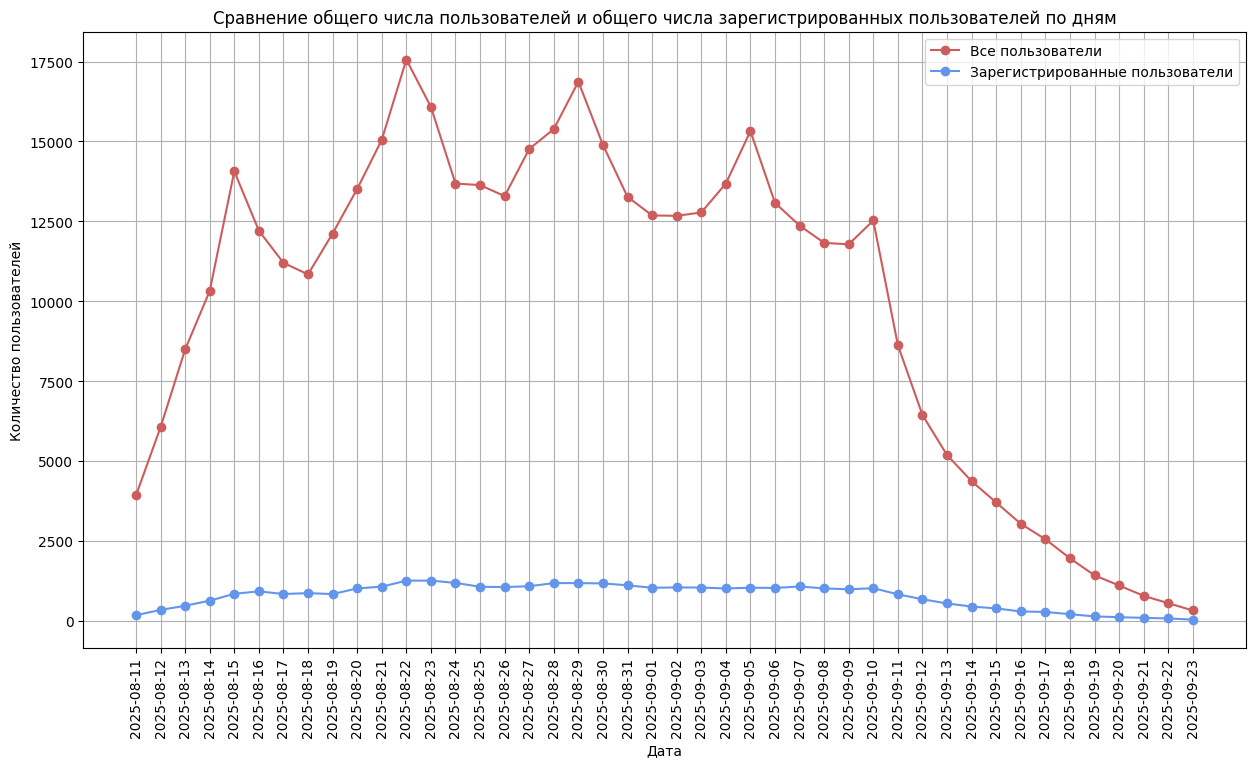

In [9]:
plt.figure(figsize=(15, 8))

plt.plot(num_unique_users.index,
         num_unique_users,
         marker='o',
         linestyle='-',
         color='indianred',
         label ='Все пользователи')

plt.plot(regis_num_users.index,
         regis_num_users,
         marker='o',
         linestyle='-',
         color='cornflowerblue',
         label ='Зарегистрированные пользователи')

plt.title('Сравнение общего числа пользователей и общего числа зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)

plt.show()

### Аналитические выводы по общему числу пользователей и зарегистрированных пользователей

- Общее число пользователей
    - В период с 11 августа по 23 августа наблюдается стабильный рост, достигая пика в 17 563 пользователя (22 августа).
    - После 11 сентября начинается снижение, особенно заметное после 16 сентября, когда трафик падает ниже 3000 пользователей в день.
    - К 23 сентября активность почти сходит на нет (317 пользователей).
    
    
- Общее число зарегистрированных пользователей
    - Динамика регистраций в целом повторяет общий трафик.
    - Пик зарегистрированных пользователей — 1253 регистрации (22 августа).
    - После 11 сентября число регистраций снижается, к 23 сентября фиксируется всего 32 регистрации.
 ---   

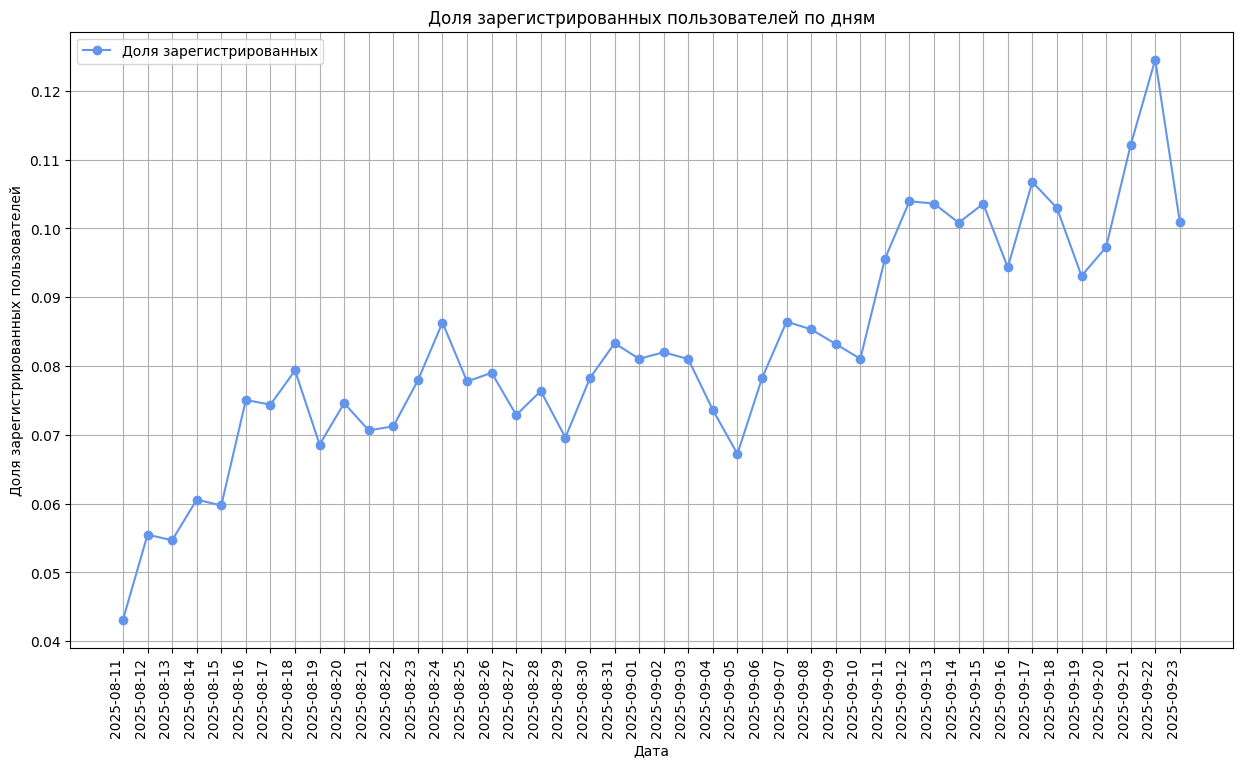

In [10]:
registered_ratio = regis_num_users / num_unique_users

plt.figure(figsize=(15, 8))
plt.plot(registered_ratio.index,
         registered_ratio,
         marker='o',
         linestyle='-',
         color='cornflowerblue',
         label='Доля зарегистрированных')

plt.title('Доля зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.legend()
plt.xticks(rotation=90, ha='right') 
plt.grid(True)

plt.show()

### Аналитические выводы по доле зарегистрированных пользователей

- Общий тренд
    - В первые недели (с 11 августа по 10 сентября) доля зарегистрированных пользователей варьируется от 4% до 8%, с небольшими колебаниями.
    - После 11 сентября начинается рост, достигая максимума 12.4% (22 сентября).
    
    
- Ключевые моменты

    - Стабильный рост в конце августа: вероятно, связано с улучшением пользовательского опыта или внешними факторами (маркетинговая активность).
    - Резкий рост после 11 сентября: возможно, снижение общего трафика повлияло на повышение регистраций среди оставшихся активных пользователей.

---

### Анализ числа просмотренных страниц

In [11]:
page_info = sessions_history.groupby('page_counter')['session_id'].count()
display(page_info)

page_counter
1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: session_id, dtype: int64

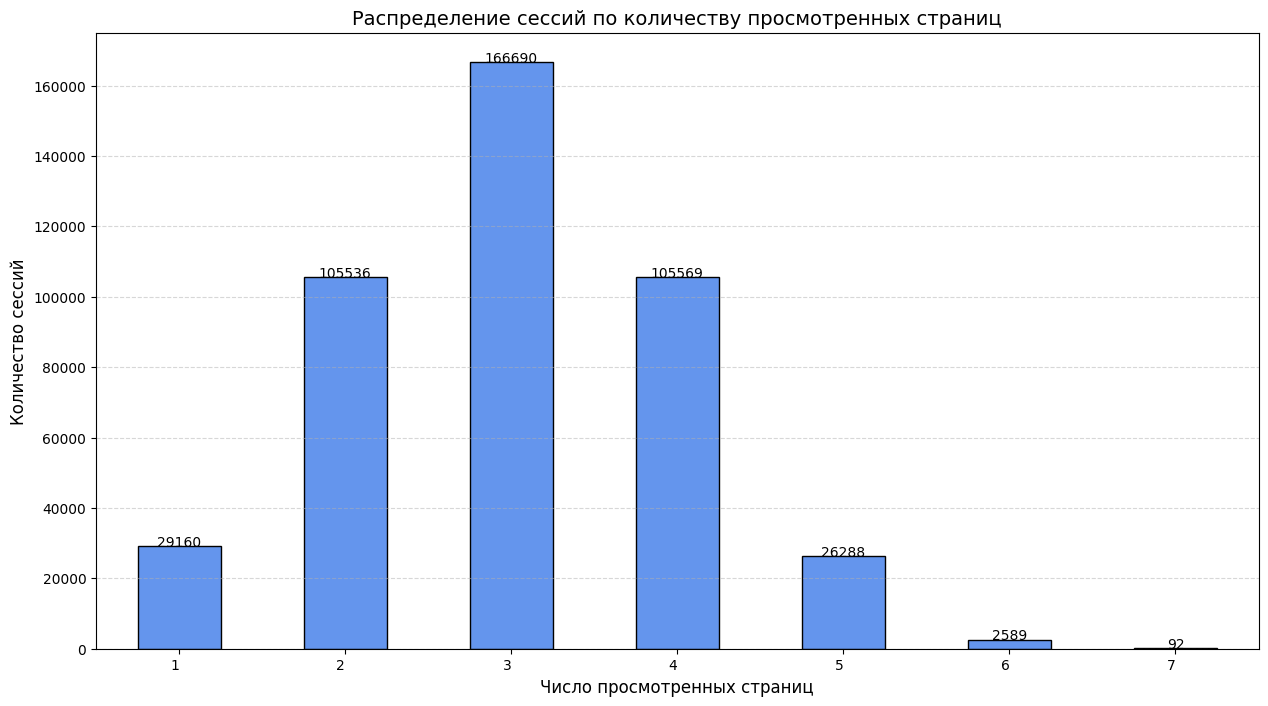

In [12]:
aa = page_info.plot( 
               kind='bar',
               figsize = (15,8),
               color='cornflowerblue',
               edgecolor='black'
)

for container in aa.patches:
    height = container.get_height()
    x = container.get_x() + container.get_width() / 2 
    aa.text(x, height + 1, str(int(height)), ha='center', fontsize=10)
    
plt.title('Распределение сессий по количеству просмотренных страниц', fontsize=14)
plt.xlabel('Число просмотренных страниц', fontsize=12)
plt.ylabel('Количество сессий', fontsize=12)
plt.xticks(rotation=0, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

### Доля пользователей, просмотревших более четырёх страниц

In [13]:
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

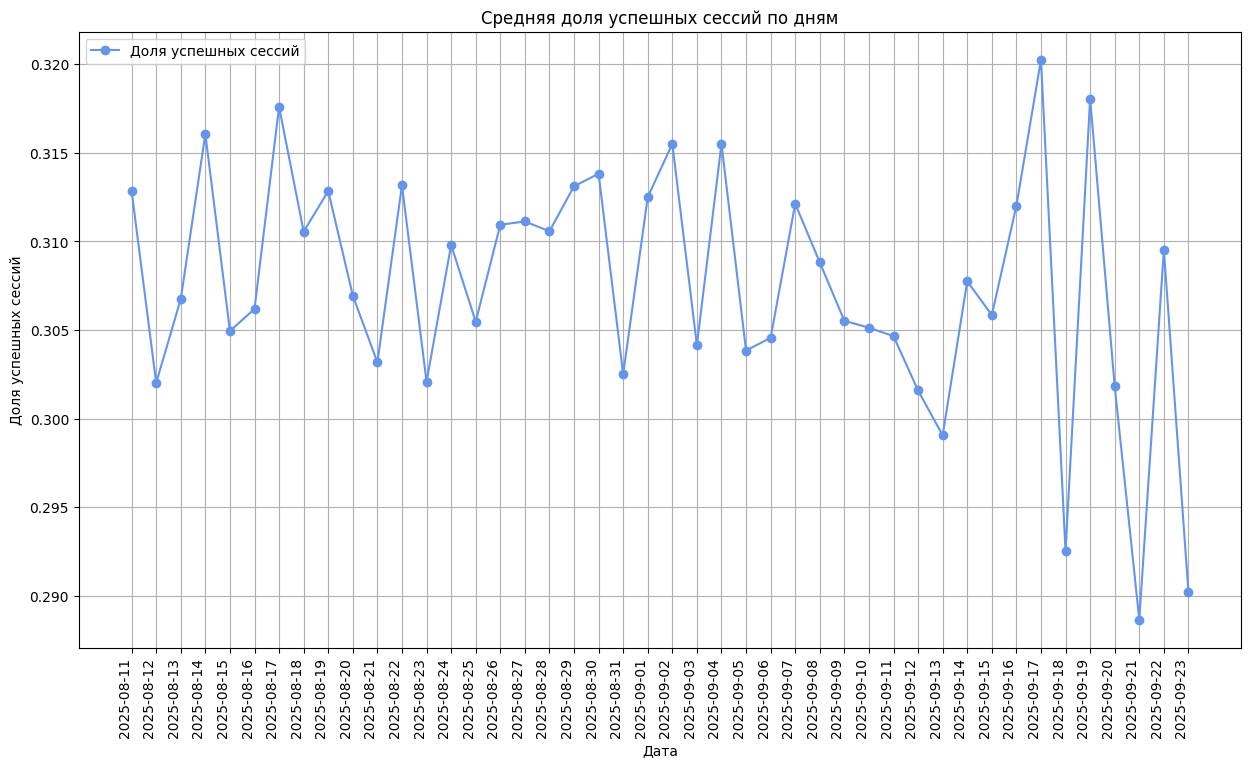

In [14]:
daily_sessions = sessions_history.groupby('session_date').agg(
    session_count=('session_id', 'count'),
    good_count=('good_session', 'sum')
)

daily_sessions['good_ratio'] = daily_sessions['good_count'] / daily_sessions['session_count']

plt.figure(figsize=(15, 8))
plt.plot(daily_sessions.index, 
         daily_sessions['good_ratio'], 
         marker='o', 
         linestyle='-', 
         color='cornflowerblue', 
         label='Доля успешных сессий')

plt.title('Средняя доля успешных сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.legend()
plt.xticks(rotation=90, ha='right')
plt.grid(True)

plt.show()

### Аналитические выводы

- Общий уровень вовлечённости
    - Доля пользователей, просмотревших более 4 страниц, колеблется в пределах ~29%–32%.
    - Среднее значение остается стабильным, без резких скачков.
    
    
- Тренды
    - Пиковые значения: 2025-09-17 (32.03%), 2025-09-19 (31.81%).
    - Минимальные значения: 2025-09-21 (28.87%), 2025-09-18 (29.25%).
    - В целом, доля удерживается в пределах 30%, но есть небольшие колебания.

## Подготовка к тесту


###  Расчёт размера выборки

In [15]:
alpha = 0.05
beta = 0.2 
power = 1 - beta
mde = 0.03

power_analysis = NormalIndPower()

sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1
)

print(f'Необходимый размер выборки для каждой группы: {int(sample_size)}')

Необходимый размер выборки для каждой группы: 17441


### Расчёт длительности A/B-теста

In [16]:
avg_daily_users = round(num_unique_users.mean())
test_duration = ceil((2*sample_size) / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дня")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дня


## Мониторинг А/В-теста

### Проверка распределения пользователей

In [17]:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

In [18]:
a_group = sessions_test_part[(sessions_test_part['test_group'] == 'A')]
b_group = sessions_test_part[(sessions_test_part['test_group'] == 'B')]

In [19]:
a_count = a_group['user_id'].nunique()
b_count = b_group['user_id'].nunique()
print(f'Количество уникальных пользователей в группе А: {a_count}')
print(f'Количество уникальных пользователей в группе B: {b_count}')

Количество уникальных пользователей в группе А: 1477
Количество уникальных пользователей в группе B: 1466


In [20]:
a_perc = 100 * a_count / sessions_test_part['user_id'].nunique()
b_perc = 100 * b_count / sessions_test_part['user_id'].nunique()
print(f'Процентная разница в количестве пользователей в группе А: {a_perc:.1f}')
print(f'Процентная разница в количестве пользователей в группе B: {b_perc:.1f}')

Процентная разница в количестве пользователей в группе А: 50.2
Процентная разница в количестве пользователей в группе B: 49.8


<function matplotlib.pyplot.show(close=None, block=None)>

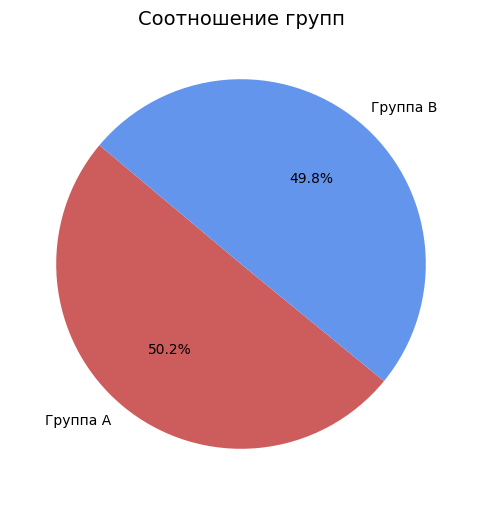

In [21]:
users_test_count =  sessions_test_part.groupby('test_group')['user_id'].nunique()
users_test_count.plot(kind='pie',
                  figsize = (12,6),
                  labels=['Группа A', 'Группа В'],
                  autopct='%1.1f%%',
                  startangle=140,
                  colors=['indianred', 'cornflowerblue']
)
plt.title('Соотношение групп', fontsize=14)
plt.ylabel('')
plt.show

### Проверка пересечений пользователей

In [22]:
a_users = a_group['user_id']
b_users = b_group['user_id']

intersection = set(a_users) & set(b_users)

print(f'Количество пользователей, которые встречаются одновременно в группах A и B: {len(intersection)}')

Количество пользователей, которые встречаются одновременно в группах A и B: 0


###  Равномерность разделения пользователей по устройствам

Количество каждого типа устройства для пользователей из группы A:


device
Android    656
Mac        156
PC         369
iPhone     296
Name: user_id, dtype: int64

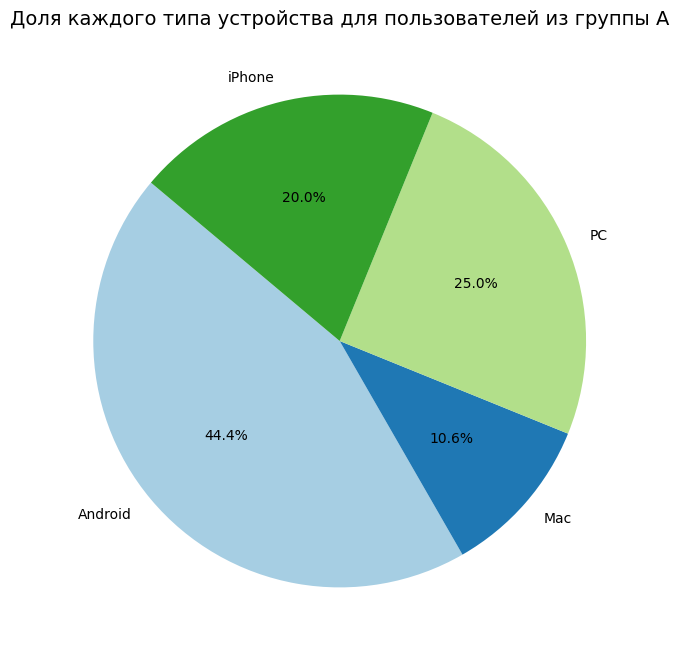

In [23]:
a_device = a_group.groupby('device')['user_id'].nunique()

a_device.plot(kind='pie',
                     figsize = (8,8),
                     autopct='%1.1f%%',
                     startangle=140,
                     colors=plt.cm.Paired.colors)
plt.title('Доля каждого типа устройства для пользователей из группы A', fontsize=14)
plt.ylabel('')

print(f'Количество каждого типа устройства для пользователей из группы A:')
display(a_device)
plt.show()

Количество каждого типа устройства для пользователей из группы B:


device
Android    668
Mac        148
PC         381
iPhone     269
Name: user_id, dtype: int64

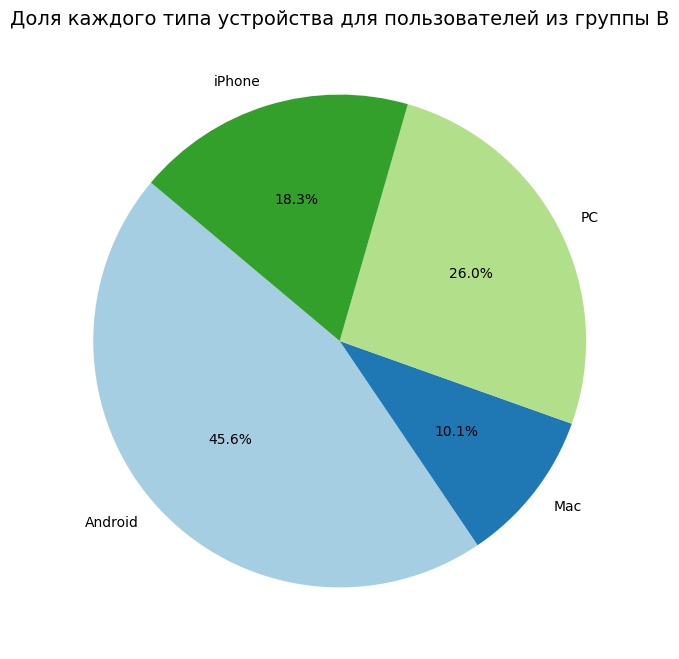

In [24]:
b_device = b_group.groupby('device')['user_id'].nunique()

b_device.plot(kind='pie',
                     figsize = (8,8),
                     autopct='%1.1f%%',
                     startangle=140,
                     colors=plt.cm.Paired.colors)
plt.title('Доля каждого типа устройства для пользователей из группы B', fontsize=14)
plt.ylabel('')

print(f'Количество каждого типа устройства для пользователей из группы B:')
display(b_device)
plt.show()

###  Равномерность распределения пользователей по регионам


Количество пользователей в группе А по регионам:


region
CIS     644
EU      224
MENA    609
Name: user_id, dtype: int64

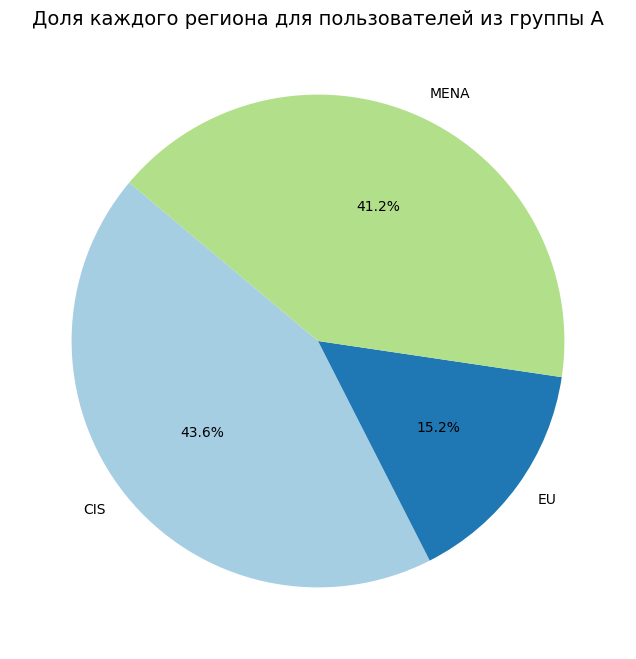

In [25]:
a_region = a_group.groupby('region')['user_id'].nunique()

a_region.plot(kind='pie',
                     figsize = (8,8),
                     autopct='%1.1f%%',
                     startangle=140,
                     colors=plt.cm.Paired.colors)
plt.title('Доля каждого региона для пользователей из группы A', fontsize=14)
plt.ylabel('')

print(f'Количество пользователей в группе А по регионам:')
display(a_region)
plt.show()

Количество пользователей в группе B по регионам:


region
CIS     645
EU      217
MENA    604
Name: user_id, dtype: int64

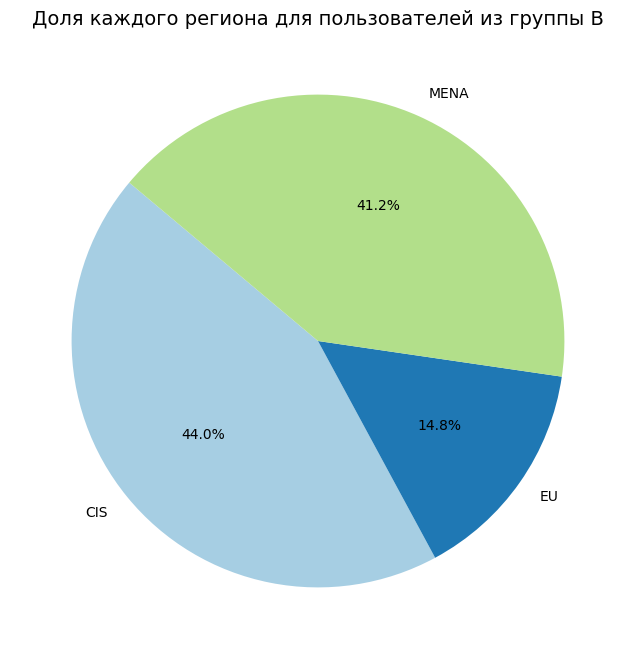

In [26]:
b_region = b_group.groupby('region')['user_id'].nunique()

b_region.plot(kind='pie',
                     figsize = (8,8),
                     autopct='%1.1f%%',
                     startangle=140,
                     colors=plt.cm.Paired.colors)
plt.title('Доля каждого региона для пользователей из группы B', fontsize=14)
plt.ylabel('')

print(f'Количество пользователей в группе B по регионам:')
display(b_region)
plt.show()

### Вывод 
- A/B-тест проводится корректно.
- Размеры выборок сбалансированы, процентное соотношение пользователей в группах A и B практически одинаково.
- Выборки независимы, пересечений пользователей между группами нет.
- Распределение пользователей по устройствам и регионам равномерное, различия незначительны и не повлияют на корректность результатов теста.
- На основе проведённой проверки можно сделать вывод, что тест проходит без нарушений, и можно переходить к анализу ключевой метрики — доли успешных сессий.

## Проверка результатов A/B-теста

###  Получение результатов теста и подсчёт основной метрики

In [27]:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [28]:
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

###  Проверка корректности результатов теста

In [29]:
dayly_session = sessions_test.groupby(['test_group', 'session_date'])['session_id'].nunique()
display(dayly_session)

test_group  session_date
A           2025-10-14      1502
            2025-10-15      2235
            2025-10-16      3280
            2025-10-17      4089
            2025-10-18      5013
            2025-10-19      6535
            2025-10-20      5837
            2025-10-21      3927
            2025-10-22      3083
            2025-10-23      2470
            2025-10-24      2090
            2025-10-25      1897
            2025-10-26      1669
            2025-10-27      1454
            2025-10-28      1279
            2025-10-29      1068
            2025-10-30       887
            2025-10-31       644
            2025-11-01       434
            2025-11-02       158
B           2025-10-14      1628
            2025-10-15      2283
            2025-10-16      3241
            2025-10-17      4054
            2025-10-18      5059
            2025-10-19      6779
            2025-10-20      6089
            2025-10-21      3981
            2025-10-22      3111
            2025-1

### Тест Стьюдента
- H₀ (нулевая гипотеза) — количество уникальных дневных сессий не различается между тестовой и контрольной группами.
- H₁ (альтернативная гипотеза) — количество уникальных дневных сессий различается между тестовой и контрольной группами.

In [30]:
sample_a = sessions_test[(sessions_test['test_group'] == 'A')].groupby('session_date')['session_id'].nunique()
sample_b = sessions_test[(sessions_test['test_group'] == 'B')].groupby('session_date')['session_id'].nunique()

alpha = 0.05

stat_ttest, p_value_ttest = ttest_ind(
    sample_a,
    sample_b,
    alternative='two-sided')

print(f'p-value теста Стьюдента = {round(p_value_ttest, 5)}')

if p_value_ttest > alpha:
    print('Нулевая гипотеза подтверждается: количество уникальных дневных сессий не различается в группах A и B')
else:
    print('Нулевая гипотеза отвергается: количество уникальных дневных сессий различается в группах A и B')

p-value теста Стьюдента = 0.93822
Нулевая гипотеза подтверждается: количество уникальных дневных сессий не различается в группах A и B


### Сравнение доли успешных сессий

In [31]:
n_a = sessions_test[sessions_test.test_group == 'A'].shape[0]
n_b = sessions_test[sessions_test.test_group == 'B'].shape[0]

m_a = sessions_test[(sessions_test.test_group == 'A')&(sessions_test.good_session==1)].shape[0]
m_b = sessions_test[(sessions_test.test_group == 'B')&(sessions_test.good_session==1)].shape[0]

p_a = m_a/n_a
p_b = m_b/n_b 
diff = p_b - p_a

print(f'Доля успешных сессий в группе A: {p_a:.3f}')
print(f'Доля успешных сессий в группе B: {p_b:.3f}')
print(f'Разница в доле успешных сессий (B - A): {diff:.3f}')

Доля успешных сессий в группе A: 0.308
Доля успешных сессий в группе B: 0.318
Разница в доле успешных сессий (B - A): 0.011


### Насколько статистически значимо изменение ключевой метрики
- H₀ (нулевая гипотеза) — разница в доле успешных сессий между группами A и B не является статистически значимой.
- H₁ (альтернативная гипотеза) — разница в доле успешных сессий между группами A и B является статистически значимой.

In [32]:
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)

print(f'pvalue={p_value_ztest}') 

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение: разница в доле успешных сессий между группами A и B не является статистически значимой.')
else:
    print('Нулевая гипотеза не находит подтверждения: разница в доле успешных сессий между группами A и B является статистически значимой.')

pvalue=0.0001574739988036123
Нулевая гипотеза не находит подтверждения: разница в доле успешных сессий между группами A и B является статистически значимой.


### Выводы по результатам A/B-теста для команды разработки

1. Характеристики эксперимента
    - Цель теста: Оценить влияние нового алгоритма рекомендаций на успешность пользовательских сессий.
    - Размер требуемой выборки: 17 441 пользователя на группу.
    - Фактический размер выборки: 15 163 уникальных пользователей в группе A, 15 416 уникальных пользователей в группе B.
    - Длительность эксперимента: 4 дня при среднем трафике 9 907 пользователей в день.
    
    
2. Влияние нового алгоритма на ключевую метрику
    - Доля успешных сессий в группе A составила 30.8%, а в группе B — 31.8%.
    - Разница между группами: +1.1% в пользу группы B.
    - Однако статистическая значимость этого увеличения не подтверждена.
    
    
3. Результаты статистических тестов
    - Сравнение количества сессий между группами: p-value = 0.9382 -> группы сопоставимы.
    - Оценка значимости разницы в доле успешных сессий:
    - p-value = 0.00015 (значительно ниже 0.05).
    - Нулевая гипотеза отвергается, разница в успешных сессиях является статистически значимой.
    
    
4. Заключение и рекомендации
    - На основе теста нет оснований утверждать, что новый алгоритм улучшает ключевую метрику.
    - Внедрять нововведение в приложение нецелесообразно без дополнительных исследований.
    - Возможно, требуется доработка алгоритма или повторное тестирование с более крупной выборкой и длительным сроком.